In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
sys.path.append('./mdlearn')
# import fitting, metrics, preprocessing, validation, dataloader
import dataloader, fitting, preprocessing

In [4]:
# parameters
class temp():
    def __init__(self):
        pass

opt = temp()
opt.input = 'data/result-ML-CH-npt.txt'
opt.target = 'density'
opt.fp = 'run/CH-npt/fp/fp_morgan1,run/CH-npt/fp/fp_simple'
opt.output = 'run/CH-npt/out'
opt.part = 'run/CH-npt/out/part-1.txt'
featrm = []
layers = [32, 16, 8]

opt.batch = 1000
opt.step = 1
opt.lr = 0.0001
opt.l2 = 0.00001

## load data

In [214]:
# read data
datax, datay, data_names = dataloader.load(filename=opt.input, fps=opt.fp.split(','), target=opt.target,
                                           featrm=featrm)
selector = preprocessing.Selector(datax, datay, data_names)
if opt.part:
    # logger.info('Loading partition file %s' % opt.part)
    selector.load(opt.part)
else:
    # logger.warning("Partition file not found. Using auto-partition instead.")
    selector.partition(0.8, 0.1)
    selector.save(opt.output + '/part.txt')
trainx, trainy, trainname = selector.training_set()
validx, validy, validname = selector.validation_set()
scaler = preprocessing.Scaler()
scaler.fit(trainx)
# scaler.save(opt.output + '/scale.txt')
normed_trainx = scaler.transform(trainx)
normed_validx = scaler.transform(validx)

model = fitting.TorchMLPRegressor(len(trainx[0]), len(trainy[0]), layers, batch_size=opt.batch, batch_step=opt.step,
                                      is_gpu= False,
                                      args_opt={'optimizer'   : torch.optim.Adam,
                                                'lr'          : opt.lr,
                                                'weight_decay': opt.l2
                                                }
                                      )
model.load(opt.output + '/model.pt')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ELU' has changed. you can retrieve the original source code by accessing the object's source attr

In [6]:
datax.shape

(181098, 126)

## Plot

In [7]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook

from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool

output_notebook()

Loading BokehJS ...

In [8]:
from bokeh.models import HoverTool
from bokeh.models import tools


import re
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools
# PandasTools ~ rdDepictor
from rdkit import DataStructs
import re

def DrawMol(mol,  kekulize=True):
    pattern = re.compile("<\?xml.*\?>")
    mc = Chem.MolFromSmiles(mol)
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        mc.Compute2DCoords()
    drawer = rdMolDraw2D.MolDraw2DSVG(100, 100)
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:', '')
    svg = re.sub(pattern, '', svg)
    return svg

# data_svg = [ DrawMol(i) for i in data_smiles_plot[:size]]
# SVG(data_svg[0])

In [215]:
data_smiles = np.array([i.split('\t')[0] for i in validname])

data_T = np.array([i.split('\t')[1] for i in validname])

data_P = np.array([i.split('\t')[2] for i in validname])

predy = model.predict_batch(torch.Tensor(normed_validx))

error_y = abs(predy - validy).reshape(-1)

In [ ]:
idx = (error_y/validy * 100 ) > 5

In [153]:
size = 100
np.random.seed(233)
perm = np.random.permutation(len(validy))[:size]

In [11]:
def mapcolor(error, threshold=5):
    if error > threshold:
        return  "#%02x%02x%02x" % (222,156, 83)
    else:
        return "#%02x%02x%02x" % (137,190,178)

In [171]:
from bokeh.models.widgets import PreText, Select
from bokeh.layouts import widgetbox
from bokeh.models import Range1d,Label
from bokeh.layouts import row
from bokeh.models import ColumnDataSource, CDSView, BooleanFilter, Slider
from bokeh.models import LassoSelectTool
from bokeh.plotting import figure, curdoc
from bokeh.models import CustomJS

In [209]:
def draw(validy, predy, smiles, T, P):
    error_y = abs(predy - validy)
    RE = error_y / validy * 100
    data_svg = [DrawMol(i) for i in smiles]
    colors = [ mapcolor(c) for c in RE ]
    TOOLS = "pan,wheel_zoom,reset, save, lasso_select"
    # TOOLTIPS = [ ("Smiles:", "@smiles"), ("T:", "@T"), ("P:", "@P"), ("log MSE:", "@error"), ("pic", "@svgs{safe}") ]
    TOOLTIPS = """
        <div>
            <div>@svgs{safe}</div>
            <div>Smiles: @smiles</div>
            <div>T: @T</div>
            <div>P: @P</div>
            <div>predy(g/cm^3): @y</div>
            <div>calc(g/cm^3): @x</div>
            <div>RelativeErr: @error %</div>
        </div>
        """
    data = ColumnDataSource({'x':validy, 'y':predy , 'smiles':smiles, 'T':T, 'P':P, 'error':RE, 'fill_color':colors, 'svgs':data_svg} )
    miny = float(min(validy))
    maxy = float(max(validy))
    p = figure( 
        title="result", tools=TOOLS,
        x_range=Range1d(0.95*miny,1.05*maxy), y_range=Range1d(0.95*miny,1.05*maxy)
    )
    hover = HoverTool()
    hover.tooltips = TOOLTIPS
    p.tools.append(hover)
    stats = PreText(text='SMILES of selected molecules are list here', width=500)
    data.callback = CustomJS(args=dict(data=data, text=stats), code="""
        var inds = data.selected.indices;
        if (inds.length == 0)
            return;

        var ym = new Array();
        for (var i = 0; i < inds.length; i++) {
            ym.push(data.data.smiles[inds[i]])
        }

        text.text = ym.join(',')

        // necessary becasue we mutated text in-place
        text.change.emit();  
    """)

    p.line([miny, maxy], [miny, maxy],line_width=1)

    
    view = CDSView(source=data, filters=[BooleanFilter(booleans)])
    p.scatter('x', 'y', radius=0.002, source=data, fill_color='fill_color', fill_alpha=1, line_color=None, view=view)
    show(row(p , stats, slider))

In [210]:
draw(validy[perm], predy[perm], np.array(data_smiles)[perm], np.array(data_T)[perm], np.array(data_P)[perm])

In [208]:
data.selected.indices

[]

In [201]:
size = 100
validy, predy, smiles, T, P = validy[:size], predy[:size], data_smiles[:size], data_T[:size], data_P[:size]

error_y = abs(predy - validy)
RE = error_y / validy * 100
data_svg = [DrawMol(i) for i in smiles]
colors = [ mapcolor(c) for c in RE ]
TOOLS = "pan,wheel_zoom,reset, save, lasso_select"
# TOOLTIPS = [ ("Smiles:", "@smiles"), ("T:", "@T"), ("P:", "@P"), ("log MSE:", "@error"), ("pic", "@svgs{safe}") ]
TOOLTIPS = """
    <div>
        <div>@svgs{safe}</div>
        <div>Smiles: @smiles</div>
        <div>T: @T</div>
        <div>P: @P</div>
        <div>predy(g/cm^3): @y</div>
        <div>calc(g/cm^3): @x</div>
        <div>RelativeErr: @error %</div>
    </div>
    """
data = ColumnDataSource({'x':validy, 'y':predy , 'smiles':smiles, 'T':T, 'P':P, 'error':RE, 'fill_color':colors, 'svgs':data_svg} )
miny = float(min(validy))
maxy = float(max(validy))
p = figure( 
    title="result", tools=TOOLS,
    x_range=Range1d(0.95*miny,1.05*maxy), y_range=Range1d(0.95*miny,1.05*maxy)
)
hover = HoverTool()
hover.tooltips = TOOLTIPS
p.tools.append(hover)
stats = PreText(text='SMILES of selected molecules are list here', width=500)
data.callback = CustomJS(args=dict(data=data, text=stats), code="""
    var inds = data.selected.indices;
    if (inds.length == 0)
        return;

    var ym = new Array();
    for (var i = 0; i < inds.length; i++) {
        ym.push(data.data.smiles[inds[i]])
    }

    text.text = ym.join(',')

    // necessary becasue we mutated text in-place
    text.change.emit();  
""")

def update_py(attr, old, new):
    threshold = slider.value
    for i in range(length(booleans)):
        if data.data['error'][i] > threshold:
            booleans[i] = True
        else:
            booleans[i] = False

slider.on_change('value', update_py)
p.line([miny, maxy], [miny, maxy],line_width=1)


view = CDSView(source=data, filters=[BooleanFilter(booleans)])
p.scatter('x', 'y', radius=0.002, source=data, fill_color='fill_color', fill_alpha=1, line_color=None, view=view)
show(row(p , stats, slider))

In [199]:
booleans.getlength

AttributeError: 'list' object has no attribute 'getlength'

In [141]:
stats.text = 'fucku'

In [142]:
stats.text

'fucku'

In [144]:
show(layout)

In [130]:
def selection_change(attrname, old, new):
    selected_idx = data.selected.indices
    smiles_str = str(smiles(selected_idx))
    stats.text = smiles_str

SyntaxError: invalid syntax (<ipython-input-130-7faf93f6e841>, line 3)

In [140]:
data.selected.indices

[]

## PCA reduction

In [54]:
# on CH-cp 124 features
size = [60, 70, 80, 90, 100, 110, 120]
var_explained = [0.854, 0.911 , 0.955, 0.985, 0.996, 0.999, 1.000]
acc2 = [  49.8, 65.2 ,64.1 , 67.7 ,73.7 ,75.2 , 77.1]
max_err = [  55.3, 39.9 ,30.4 , 32.7 ,40.4 ,48.2 , 43.5]
acc2base, maxErrbase = [69.8, 58.6]

Text(0,0.5,'Variance explained')

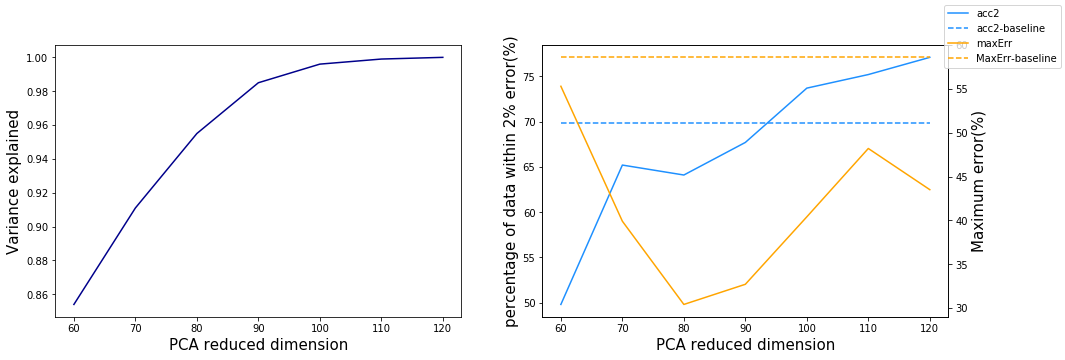

In [55]:
fig = plt.figure(figsize=[16,5])
ax1 = fig.add_subplot(122)
font_size = 15
handle1 = ax1.plot(size, acc2, label='acc2', color='dodgerblue')
ax1.set_xlabel('PCA reduced dimension', size=font_size)
ax1.set_ylabel('percentage of data within 2% error(%)', size=font_size)
ax1.plot([60,120], [acc2base, acc2base],label='acc2-baseline', color='dodgerblue', linestyle='--')

ax2 = ax1.twinx()  # this is the important function
handle2 = ax2.plot(size, max_err,color='orange', label='maxErr')
ax2.plot([60,120], [maxErrbase, maxErrbase],label='MaxErr-baseline',color='orange', linestyle='--')
ax2.set_ylabel('Maximum error(%)', size=font_size)
fig.legend()

ax3 = fig.add_subplot(121)
ax3.plot(size, var_explained, 'darkblue')
ax3.set_xlabel('PCA reduced dimension', size=font_size)
ax3.set_ylabel("Variance explained", size=font_size)
# ax1.legend([handle1, handle2], ['acc2', 'MaxErr'],loc='lower right')
# ax1 = plt.gca()
